<a href="https://colab.research.google.com/github/mansiraturi/RFM_Analysis/blob/main/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Customer Segmentation using RFM Analysis**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

import sklearn.linear_model as skl_lm
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.model_selection import train_test_split

Data Acquisition

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
customer= pd.read_csv('/content/drive/MyDrive/proj2/dataset.csv',  encoding='ISO-8859-1' )

Data Inspection

In [4]:
customer.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


**1. DATA PREPROCESSING**

In [5]:
customer.shape

(541909, 8)

In [6]:
customer.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

Handling Missing Data

In [7]:
print(customer.isnull().mean())
#missing_vals = [ft for ft in customer.columns if customer[ft].isnull()]

InvoiceNo      0.000000
StockCode      0.000000
Description    0.002683
Quantity       0.000000
InvoiceDate    0.000000
UnitPrice      0.000000
CustomerID     0.249267
Country        0.000000
dtype: float64


In [8]:
#customer['CustomerID'].fillna(0, inplace=True)

In [9]:
customer = customer.dropna(subset=['CustomerID'])

In [10]:
negative_quantities = customer[customer['Quantity'] < 0]
print(len(negative_quantities)/len(customer))

0.021888803403887137


Converting column values to appropriate datatypes

In [11]:
import pandas as pd
import re
# Convert the date and time columns to date-time datatype
customer['InvoiceDate'] = pd.to_datetime(customer['InvoiceDate'], format='%m/%d/%Y %H:%M')
customer['CustomerID'] = customer['CustomerID'].astype(int)

**2. RFM CALCULATION**

In [12]:
customer['Total Price'] = customer['UnitPrice']*customer['Quantity']
customer.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total Price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [13]:
#Recency
current_date = customer['InvoiceDate'].max()
recency_data = customer.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency_data['Recency'] = (current_date - recency_data['InvoiceDate']).dt.days
recency_data.drop('InvoiceDate', axis=1, inplace=True)
# Display the Recency data
print(recency_data.head())


   CustomerID  Recency
0       12346      325
1       12347        1
2       12348       74
3       12349       18
4       12350      309


In [14]:
# Frequency (F)
frequency_data = customer.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
frequency_data.rename(columns={'InvoiceNo': 'Frequency'}, inplace=True)
print(frequency_data.head())


   CustomerID  Frequency
0       12346          2
1       12347          7
2       12348          4
3       12349          1
4       12350          1


This is the distribution of number of orders per customers

In [15]:
# Monetary (M)
monetary_df = customer.groupby('CustomerID')['Total Price'].sum().reset_index()
monetary_df.rename(columns={'Total Price': 'Monetary'}, inplace=True)
print(monetary_df.head())


   CustomerID  Monetary
0       12346      0.00
1       12347   4310.00
2       12348   1797.24
3       12349   1757.55
4       12350    334.40


In [16]:
# Merge Recency, Frequency, and Monetary metrics into a single DataFrame
rfm_df = pd.merge(recency_data[['CustomerID', 'Recency']], frequency_data, on='CustomerID')
rfm_df = pd.merge(rfm_df, monetary_df, on='CustomerID')

# Display the RFM DataFrame
print(rfm_df)

      CustomerID  Recency  Frequency  Monetary
0          12346      325          2      0.00
1          12347        1          7   4310.00
2          12348       74          4   1797.24
3          12349       18          1   1757.55
4          12350      309          1    334.40
...          ...      ...        ...       ...
4367       18280      277          1    180.60
4368       18281      180          1     80.82
4369       18282        7          3    176.60
4370       18283        3         16   2094.88
4371       18287       42          3   1837.28

[4372 rows x 4 columns]


**3. RFM SEGMENTATION**

In [17]:
import pandas as pd
quartile = [0, 0.25, 0.5, 0.75, 1]
# Calculate quantiles for Recency, Frequency, and Monetary
recency_quartiles = pd.qcut(rfm_df['Recency'], q=quartile, labels=False, duplicates='drop')
frequency_quartiles = pd.qcut(rfm_df['Frequency'], q=quartile, labels=False, duplicates='drop')
monetary_quartiles = pd.qcut(rfm_df['Monetary'], q=quartile, labels=False, duplicates='drop')

# Assign quartile scores to each customer
rfm_df['RecencyScore'] = recency_quartiles + 1  # Add 1 to start scores from 1 instead of 0
rfm_df['FrequencyScore'] = frequency_quartiles + 1
rfm_df['MonetaryScore'] = monetary_quartiles + 1

# Combine the RFM scores to create a single RFM score for each customer
#Here we calculate a weighted RFM score
rfm_df['RFMScore'] = rfm_df['RecencyScore'] * 100 + rfm_df['FrequencyScore'] * 10 + rfm_df['MonetaryScore']

# Display the updated RFM DataFrame with scores
print(rfm_df)


      CustomerID  Recency  Frequency  Monetary  RecencyScore  FrequencyScore  \
0          12346      325          2      0.00             4               1   
1          12347        1          7   4310.00             1               3   
2          12348       74          4   1797.24             3               2   
3          12349       18          1   1757.55             2               1   
4          12350      309          1    334.40             4               1   
...          ...      ...        ...       ...           ...             ...   
4367       18280      277          1    180.60             4               1   
4368       18281      180          1     80.82             4               1   
4369       18282        7          3    176.60             1               1   
4370       18283        3         16   2094.88             1               3   
4371       18287       42          3   1837.28             2               1   

      MonetaryScore  RFMScore  
0      

In [18]:
# rfm_data2 = rfm_df['RFMScore']

**4. CUSTOMER SEGMENTATION**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

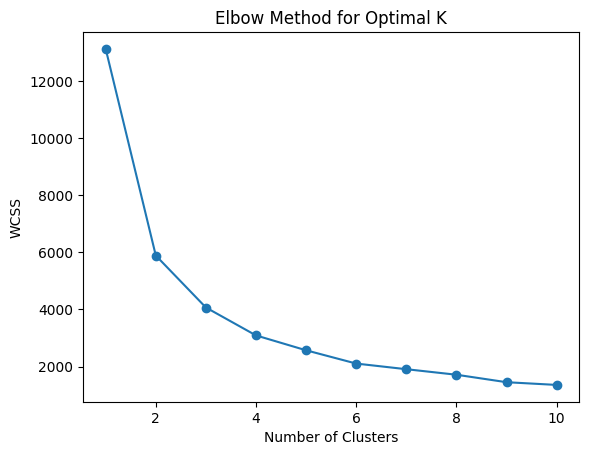

In [19]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Select RFM features for clustering
rfm_data = rfm_df[['RecencyScore', 'FrequencyScore', 'MonetaryScore']]

# Standardize the data (important for K-Means)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data)

# Determine the optimal number of clusters using the Elbow Method
wcss = []  # Within-Cluster-Sum-of-Squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')  # Within-Cluster-Sum-of-Squares
plt.show()

In [20]:
rfm_scaled

array([[ 1.34632715, -0.76266201, -1.34164079],
       [-1.32110894,  1.58630475,  1.34164079],
       [ 0.45718179,  0.41182137,  1.34164079],
       ...,
       [-1.32110894, -0.76266201, -1.34164079],
       [-1.32110894,  1.58630475,  1.34164079],
       [-0.43196358, -0.76266201,  1.34164079]])

In [21]:
#Silhoutte score
from sklearn.metrics import silhouette_samples, silhouette_score
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
import matplotlib.cm as cm

In [22]:
clusterer = KMeans(n_clusters=4, random_state=10)
cluster_labels = clusterer.fit_predict(rfm_scaled)
print(cluster_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[2 1 0 ... 3 1 0]


In [23]:
rfm_df

,CustomerID,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFMScore
0,12346,325,2,0.00,4,1,1,411
1,12347,1,7,4310.00,1,3,4,134
2,12348,74,4,1797.24,3,2,4,324
3,12349,18,1,1757.55,2,1,4,214
4,12350,309,1,334.40,4,1,2,412
...,...,...,...,...,...,...,...,...
4367,18280,277,1,180.60,4,1,1,411
4368,18281,180,1,80.82,4,1,1,411
4369,18282,7,3,176.60,1,1,1,111
4370,18283,3,16,2094.88,1,3,4,134


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 2 The average silhouette_score is : 0.48937710917650723


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 3 The average silhouette_score is : 0.45051668632826836


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 4 The average silhouette_score is : 0.4516219838900886


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 5 The average silhouette_score is : 0.4487218045392053


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 6 The average silhouette_score is : 0.4767251686301523


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 7 The average silhouette_score is : 0.4778554015091838


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 8 The average silhouette_score is : 0.5029914153339486


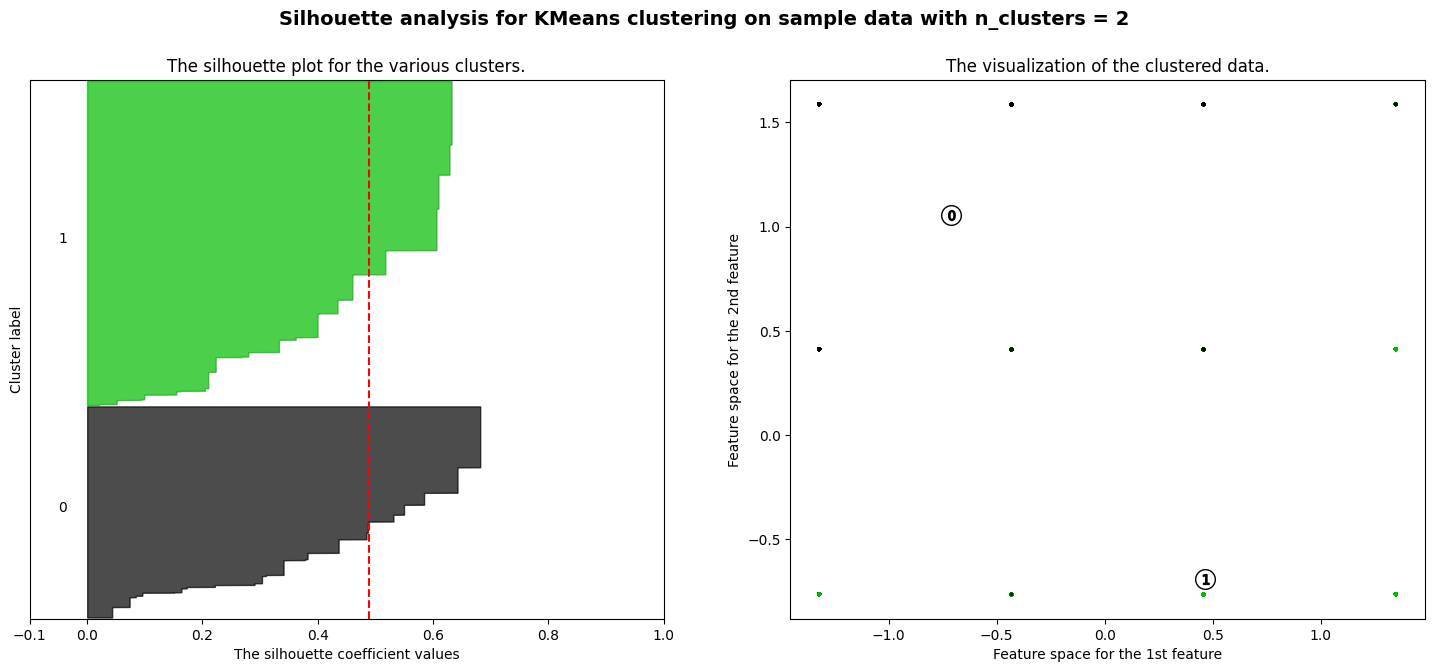

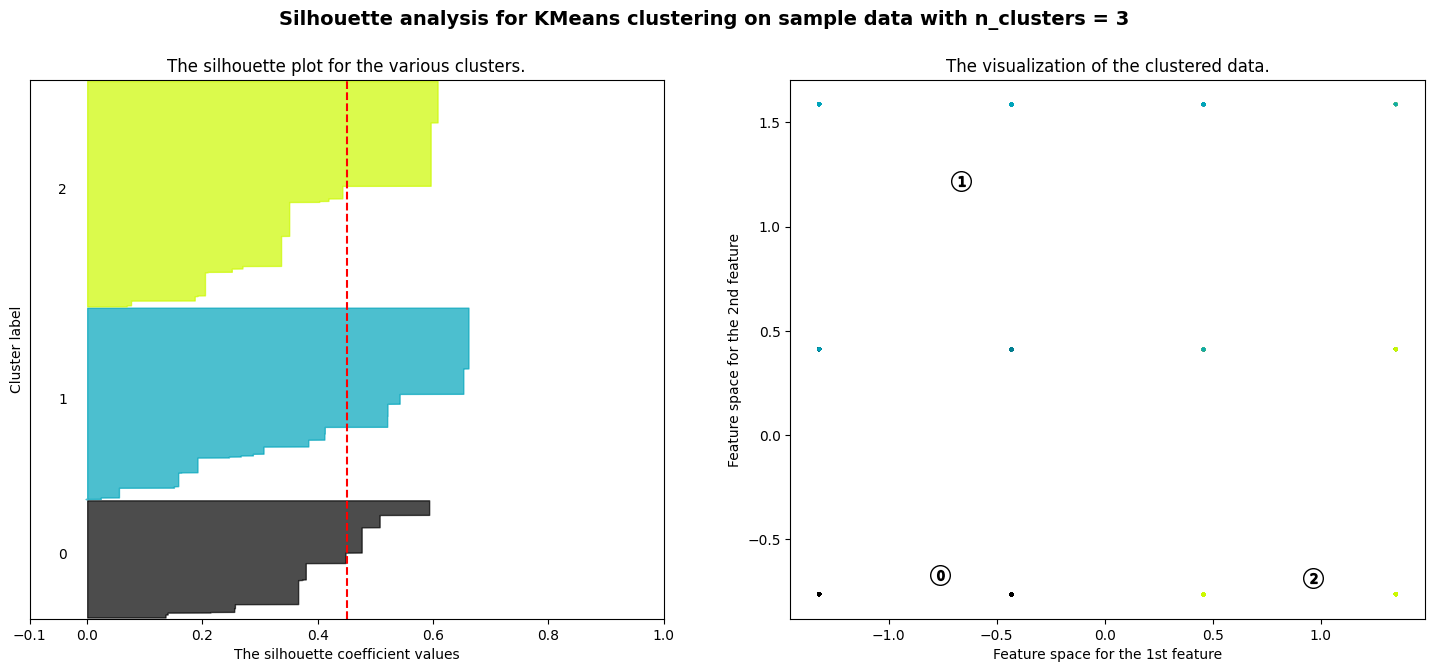

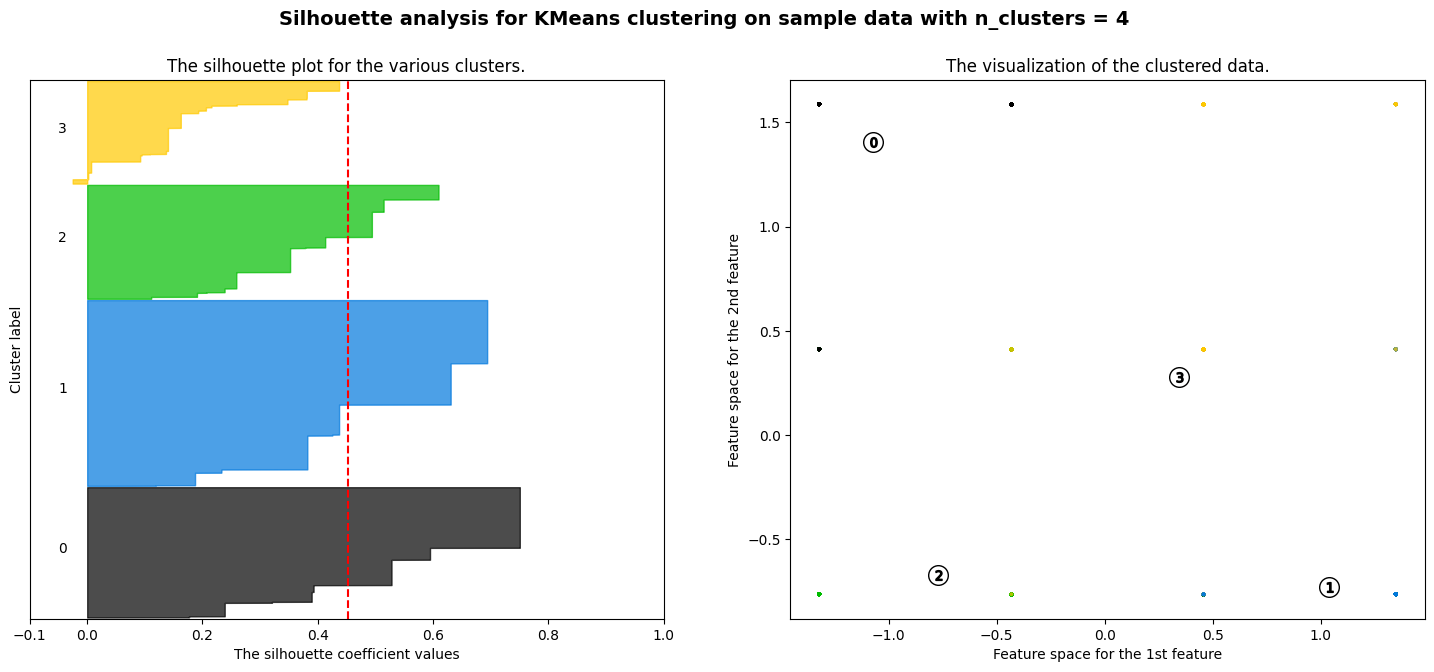

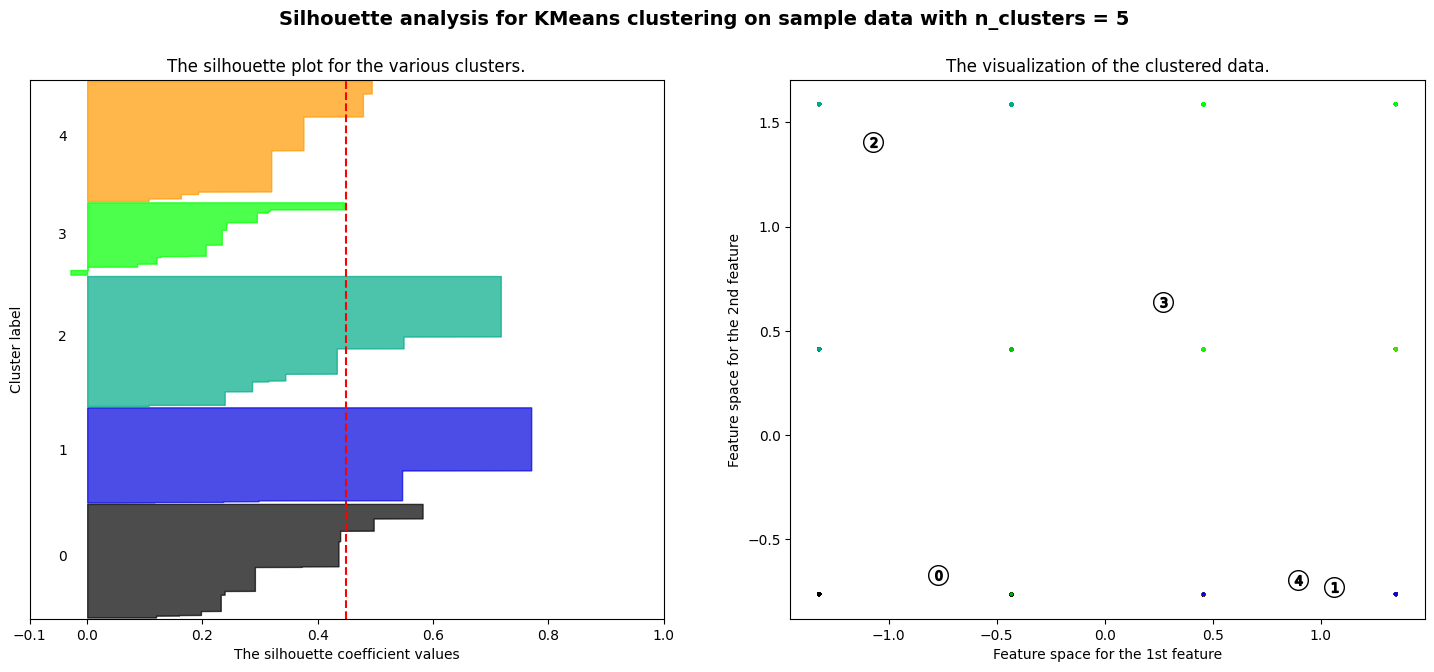

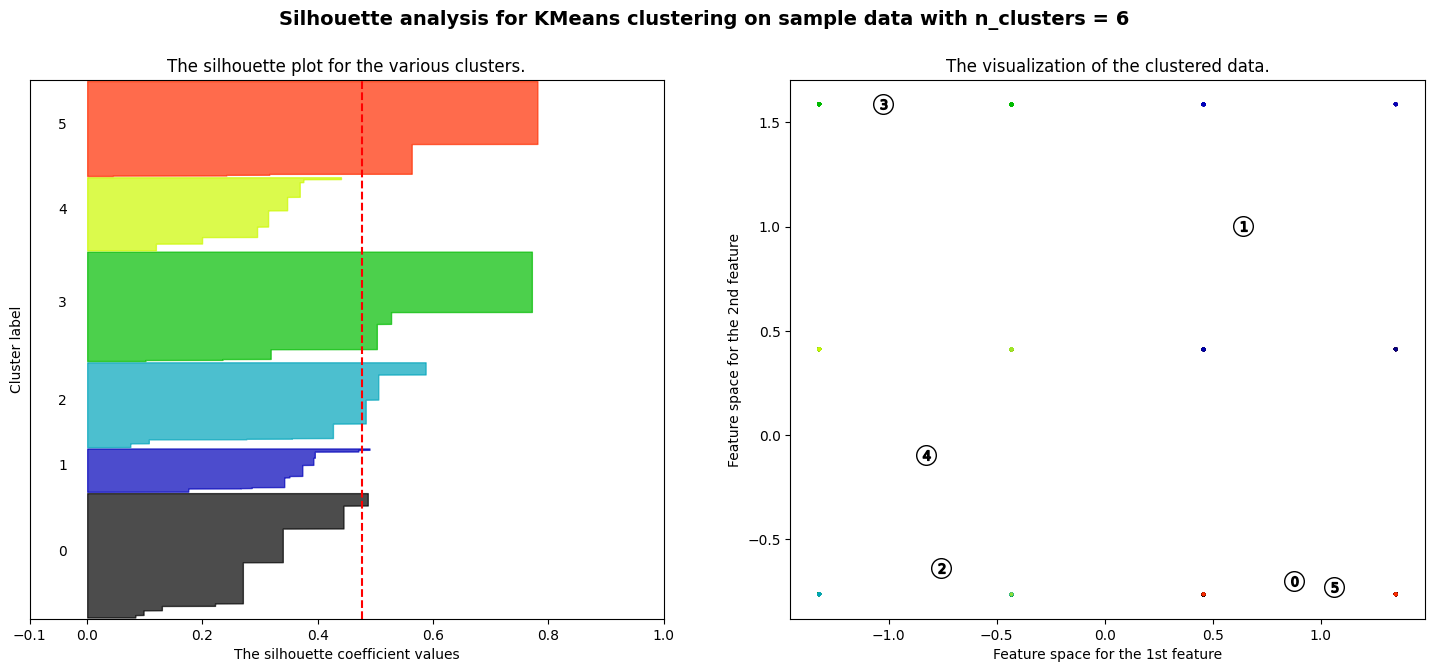

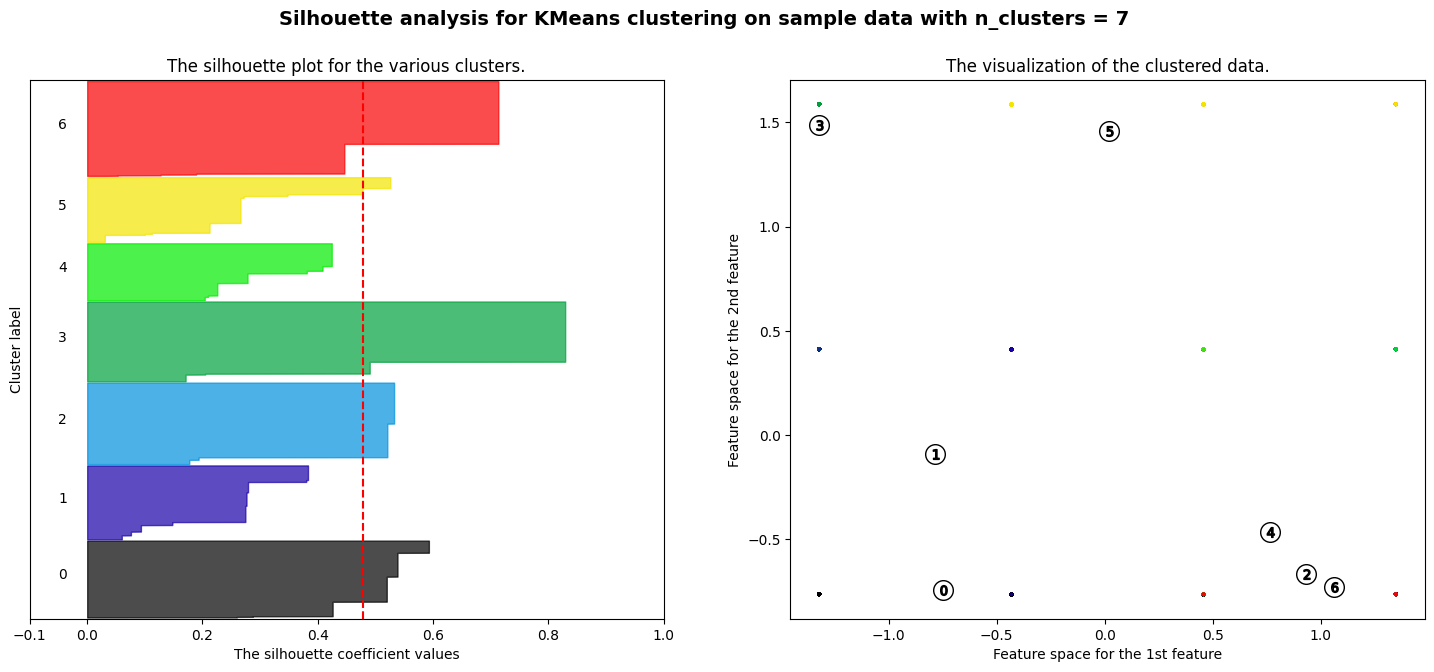

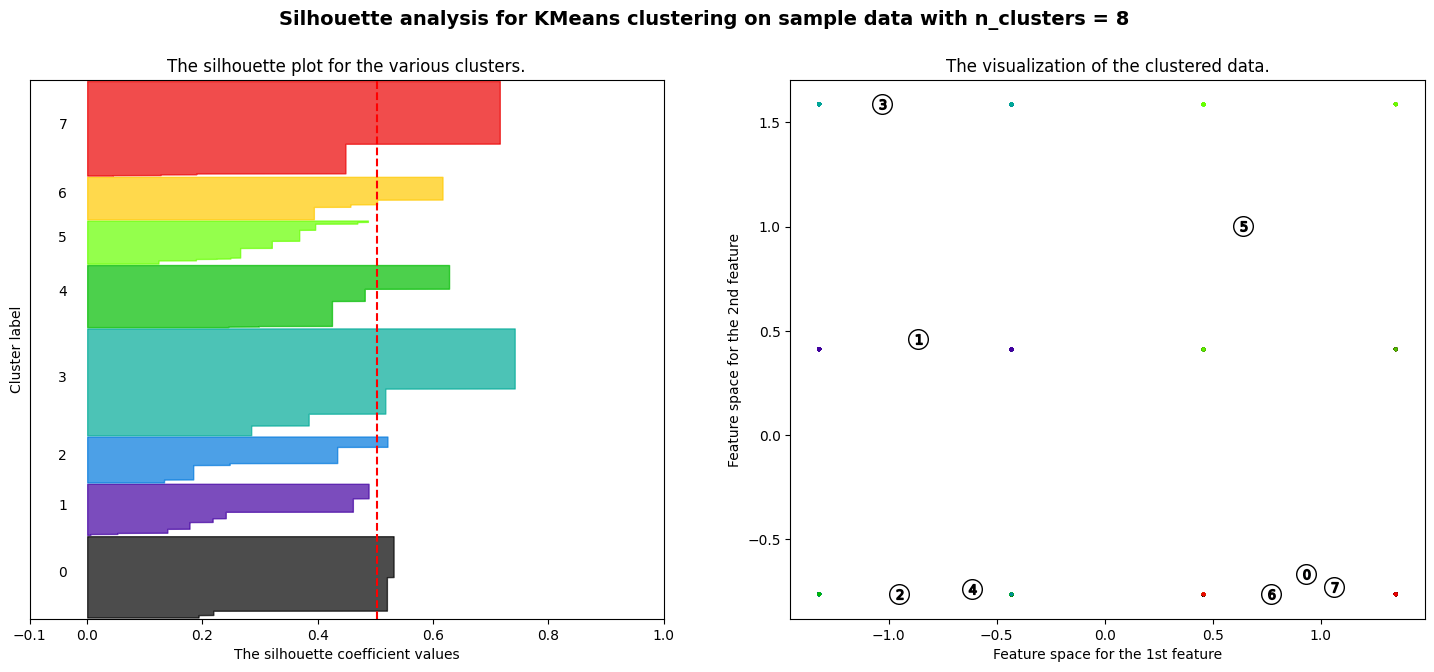

In [24]:
for n_clust in range_n_clusters:
     # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(rfm_scaled) + (n_clust + 1) * 10])

    clusterer = KMeans(n_clusters=  n_clust)
    cluster_labels = clusterer.fit_predict(rfm_scaled)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    sil_avg = silhouette_score(rfm_scaled, cluster_labels)
    print("For n_clusters =", n_clust, "The average silhouette_score is :", sil_avg)

    sample_silval = silhouette_samples(rfm_scaled, cluster_labels)
    sample_silval = sample_silval if isinstance(sample_silval, np.ndarray) else sample_silval.values

    y_lower = 10
    for i in range(n_clust):
      ith_clust_silval = sample_silval[cluster_labels == i]
      ith_clust_silval.sort()
      size_clusteri = ith_clust_silval.shape[0]
      y_upper = y_lower + size_clusteri
      color = cm.nipy_spectral(float(i) / n_clust)
      ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_clust_silval, facecolor=color, edgecolor=color, alpha=0.7)
    # Label the silhouette plots with their cluster numbers at the middle
      ax1.text(-0.05, y_lower + 0.5 * size_clusteri, str(i))
      # Compute the new y_lower for the next plot
      y_lower = y_upper + 10  # 10 for the 0 samples


    # sample_silval = silhouette_samples(rfm_data, cluster_labels)
    # sample_silval = sample_silval.values if isinstance(sample_silval, pd.DataFrame) else sample_silval

    # y_lower = 10
    # for i in range(n_clust):
    #   # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
    #   ith_clust_silval  = sample_silval[cluster_labels==i]
    #   ith_clust_silval.sort()
    #   size_clusteri = ith_clust_silval.shape[0]
    #   y_upper=  y_lower+size_clusteri
    #   color = cm.nipy_spectral(float(i) / n_clust)
    #   ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_clust_silval,facecolor=color, edgecolor=color, alpha=0.7)

    #     # Label the silhouette plots with their cluster numbers at the middle
    #   ax1.text(-0.05, y_lower + 0.5 * size_clusteri, str(i))

    #     # Compute the new y_lower for next plot
    #   y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

     # The vertical line for average silhouette score of all the values
    ax1.axvline(x=sil_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clust)
    ax2.scatter(rfm_scaled[:, 0], rfm_scaled[:, 1], marker='.', s=30, lw=0, alpha=0.7,c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
      ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clust),
                 fontsize=14, fontweight='bold')


plt.show()


In [25]:
rfm_scaled

array([[ 1.34632715, -0.76266201, -1.34164079],
       [-1.32110894,  1.58630475,  1.34164079],
       [ 0.45718179,  0.41182137,  1.34164079],
       ...,
       [-1.32110894, -0.76266201, -1.34164079],
       [-1.32110894,  1.58630475,  1.34164079],
       [-0.43196358, -0.76266201,  1.34164079]])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

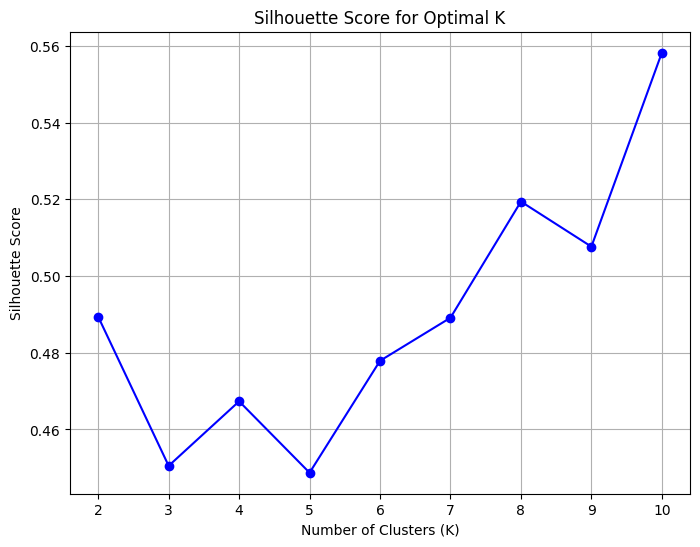

In [26]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    cluster_labels = kmeans.fit_predict(rfm_scaled)
    silhouette_avg = silhouette_score(rfm_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Silhouette Score graph
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='-', color='b')
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [27]:
from sklearn.manifold import TSNE

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


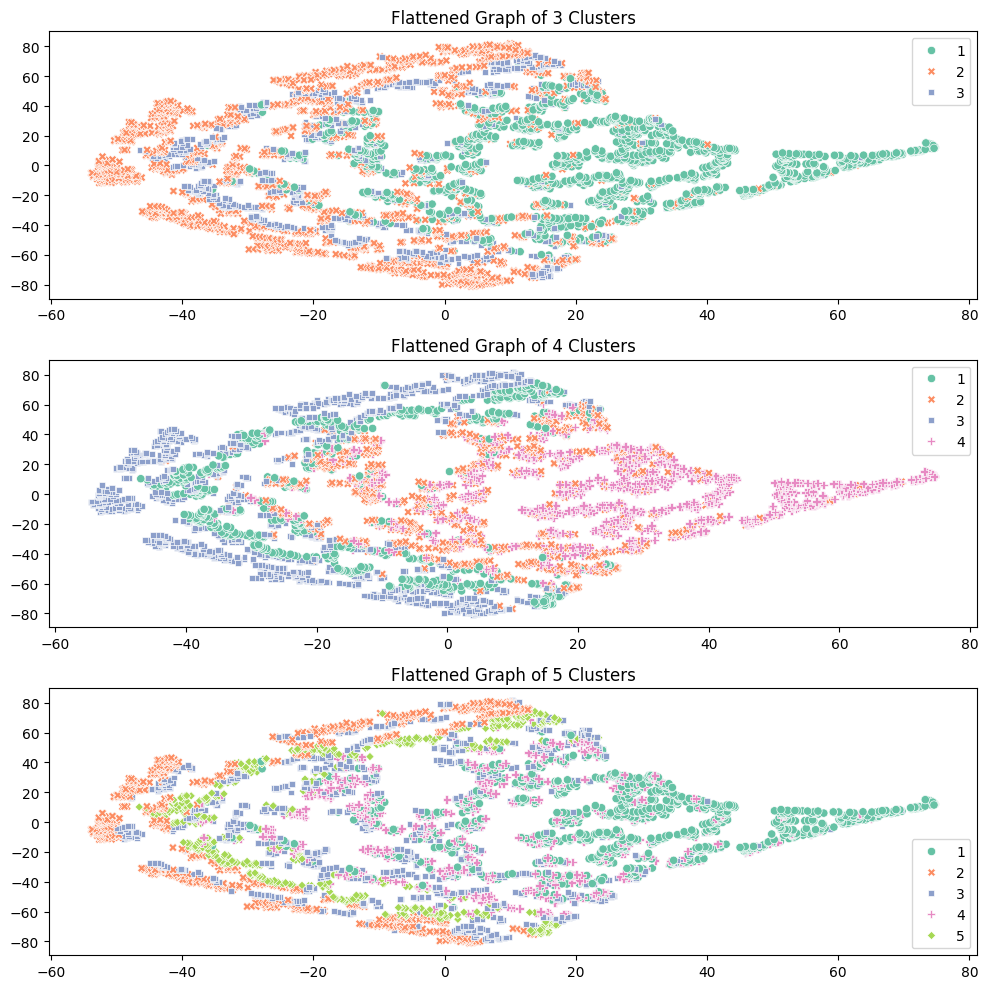

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

def kmeans(rfm_scaled, clusters_number, rfm_df):

    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(rfm_scaled)
# Extract cluster labels
    cluster_labels = kmeans.labels_+1

    # Create a cluster label column in original dataset
    df_new = rfm_df.assign(Cluster = cluster_labels)

    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)

    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set2")

    return df_new
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
df_rfm_k3 = kmeans(rfm_scaled, 3, rfm_df)
plt.subplot(3, 1, 2)
df_rfm_k4 = kmeans(rfm_scaled, 4, rfm_df)
plt.subplot(3, 1, 3)
df_rfm_k5 = kmeans(rfm_scaled, 5, rfm_df)
plt.tight_layout()

**5. Segment Profiling**

In [29]:
# Apply K-Means clustering with the chosen K
kmeans = KMeans(n_clusters=4, random_state=0)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_scaled)+1

# Analyze and interpret the clusters
cluster_centers = kmeans.cluster_centers_
cluster_sizes = rfm_df['Cluster'].value_counts()
cluster_sizes

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


2    1466
1    1415
3     786
4     705
Name: Cluster, dtype: int64

In [30]:
# Analyze and profile each customer segment
for cluster_label in range(kmeans.n_clusters):
    cluster_data = rfm_df[rfm_df['Cluster'] == cluster_label]

    print(f"\n\n------ Profile for Cluster {cluster_label} ------")

    # General statistics
    print("Cluster Size:", len(cluster_data))

    # RFM scores
    print("Recency:")
    print(" - Mean:", cluster_data['RecencyScore'].mean())
    print(" - Min:", cluster_data['RecencyScore'].min())
    print(" - Max:", cluster_data['RecencyScore'].max())

    print("\nFrequency:")
    print(" - Mean:", cluster_data['FrequencyScore'].mean())
    print(" - Min:", cluster_data['FrequencyScore'].min())
    print(" - Max:", cluster_data['FrequencyScore'].max())

    print("\nMonetary Value:")
    print(" - Mean:", cluster_data['MonetaryScore'].mean())
    print(" - Min:", cluster_data['MonetaryScore'].min())
    print(" - Max:", cluster_data['MonetaryScore'].max())



------ Profile for Cluster 0 ------
Cluster Size: 0
Recency:
 - Mean: nan
 - Min: nan
 - Max: nan

Frequency:
 - Mean: nan
 - Min: nan
 - Max: nan

Monetary Value:
 - Mean: nan
 - Min: nan
 - Max: nan


------ Profile for Cluster 1 ------
Cluster Size: 1415
Recency:
 - Mean: 1.5943462897526501
 - Min: 1
 - Max: 4

Frequency:
 - Mean: 2.758303886925795
 - Min: 2
 - Max: 3

Monetary Value:
 - Mean: 3.6367491166077737
 - Min: 2
 - Max: 4


------ Profile for Cluster 2 ------
Cluster Size: 1466
Recency:
 - Mean: 3.6132332878581175
 - Min: 3
 - Max: 4

Frequency:
 - Mean: 1.0661664392905865
 - Min: 1
 - Max: 3

Monetary Value:
 - Mean: 1.465211459754434
 - Min: 1
 - Max: 2


------ Profile for Cluster 3 ------
Cluster Size: 786
Recency:
 - Mean: 1.5623409669211197
 - Min: 1
 - Max: 2

Frequency:
 - Mean: 1.0966921119592876
 - Min: 1
 - Max: 3

Monetary Value:
 - Mean: 1.7162849872773538
 - Min: 1
 - Max: 3


In [31]:
rfm_df["RFMScore"] = rfm_df["RFMScore"].astype(str)

In [32]:
# Segmentation map
seg_map = {
    r'[1-2][1-4][4]': 'High-Value and Recently Active Customers',
    r'[1-2][3-4][1-4]': 'Regular but Less Recent Customers',
    r'[1-4][3-4][4]': 'High-Frequency but Lower Monetary Value',
    r'[1-4][1-2][1-2]': 'Infrequent and Low-Value Customers'
}

# Create segment using RF_Score and segmap
rfm_df["segment"] = rfm_df["RFMScore"].replace(seg_map, regex=True)

# Remove any numeric values from the "segment" column
rfm_df["segment"] = rfm_df["segment"].str.replace('\d+', '', regex=True)

# Display the updated DataFrame
print(rfm_df.head())


   CustomerID  Recency  Frequency  Monetary  RecencyScore  FrequencyScore  \
0       12346      325          2      0.00             4               1   
1       12347        1          7   4310.00             1               3   
2       12348       74          4   1797.24             3               2   
3       12349       18          1   1757.55             2               1   
4       12350      309          1    334.40             4               1   

   MonetaryScore RFMScore  Cluster                                   segment  
0              1      411        2        Infrequent and Low-Value Customers  
1              4      134        1  High-Value and Recently Active Customers  
2              4      324        4                                            
3              4      214        4  High-Value and Recently Active Customers  
4              2      412        2        Infrequent and Low-Value Customers  


In [33]:
rfm_df[["segment", "Recency", "Frequency", "Monetary"]].groupby("segment").agg(["mean", "sum", "count"])

Recency                Frequency  \
                                                mean     sum count       mean   
segment                                                                         
                                           79.855796   84727  1061   3.452403   
High-Frequency but Lower Monetary Value    91.066667    9562   105   9.228571   
High-Value and Recently Active Customers   13.730455   11767   857  14.457410   
Infrequent and Low-Value Customers        134.155669  288703  2152   1.703067   
Regular but Less Recent Customers          16.746193    3299   197   7.629442   

                                                          Monetary  \
                                            sum count         mean   
segment                                                              
                                           3663  1061  1191.884648   
High-Frequency but Lower Monetary Value     969   105  3354.821429   
High-Value and Recently Active Customers  12390   857  6791.435333   
Infrequent and Low-Value Customers         3665  2152   295.622845   
Regular but Less Recent Customers          1503   197  1151.165025   

                                                             
                                                  sum count  
segment                                                      
                                          1264589.612  1061  
High-Frequency but Lower Monetary Value    352256.250   105  
High-Value and Recently Active Customers  5820260.080   857  
Infrequent and Low-Value Customers         636180.362  2152  
Regular but Less Recent Customers          226779.510   197


--- Customer Segment 2 ---
Number of Customers: 1466

RFM Statistics:
           Recency    Frequency     Monetary
count  1466.000000  1466.000000  1466.000000
mean    188.210095     1.624147   278.987355
std      99.423949     1.011843   221.907603
min      50.000000     1.000000 -4287.630000
25%      91.000000     1.000000   153.910000
50%     183.000000     1.000000   271.145000
75%     268.000000     2.000000   402.950000
max     373.000000     9.000000   647.740000


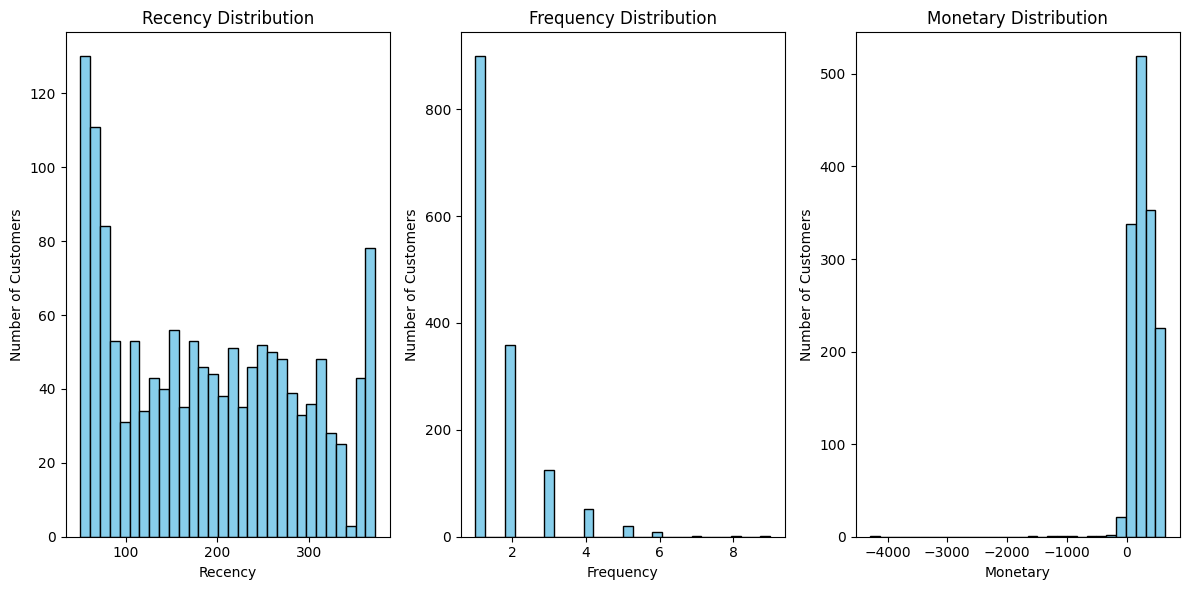


--- Customer Segment 1 ---
Number of Customers: 1415

RFM Statistics:
           Recency    Frequency       Monetary
count  1415.000000  1415.000000    1415.000000
mean     24.365371    11.497527    4660.281287
std      33.373631    14.343378   14008.014980
min       0.000000     4.000000     306.720000
25%       4.000000     6.000000    1313.635000
50%      15.000000     8.000000    2187.310000
75%      30.000000    12.000000    3874.850000
max     301.000000   248.000000  279489.020000


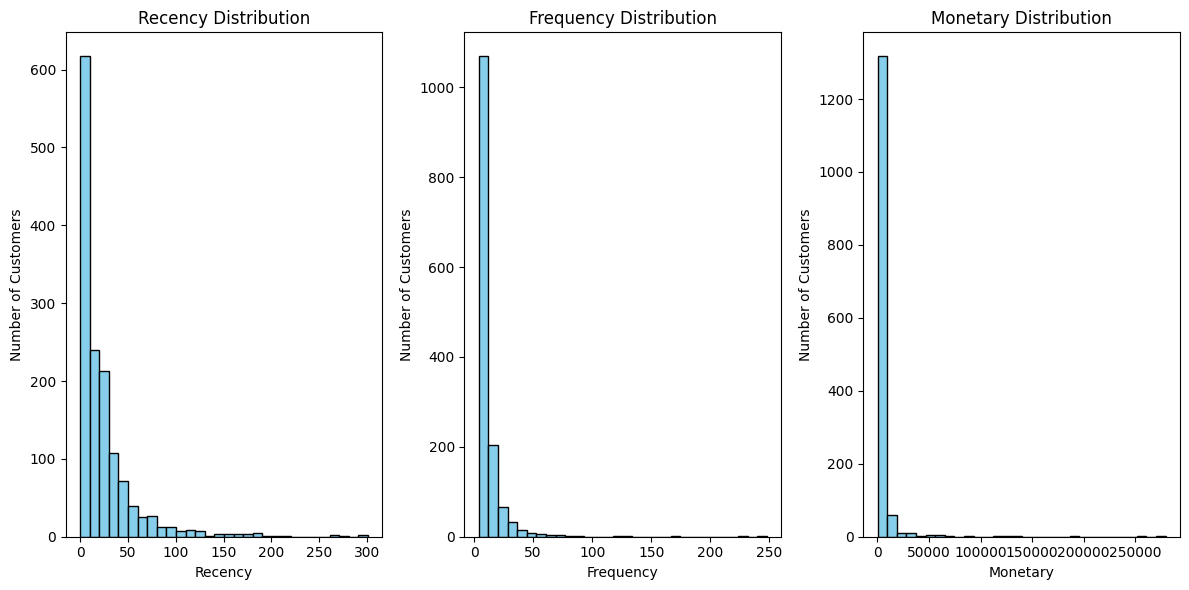


--- Customer Segment 4 ---
Number of Customers: 705

RFM Statistics:
          Recency   Frequency      Monetary
count  705.000000  705.000000    705.000000
mean   101.202837    2.758865   1392.355604
std     76.176623    1.217187   1262.926565
min      1.000000    1.000000    648.410000
25%     50.000000    2.000000    789.890000
50%     77.000000    3.000000   1048.670000
75%    134.000000    4.000000   1586.810000
max    371.000000    5.000000  21535.900000


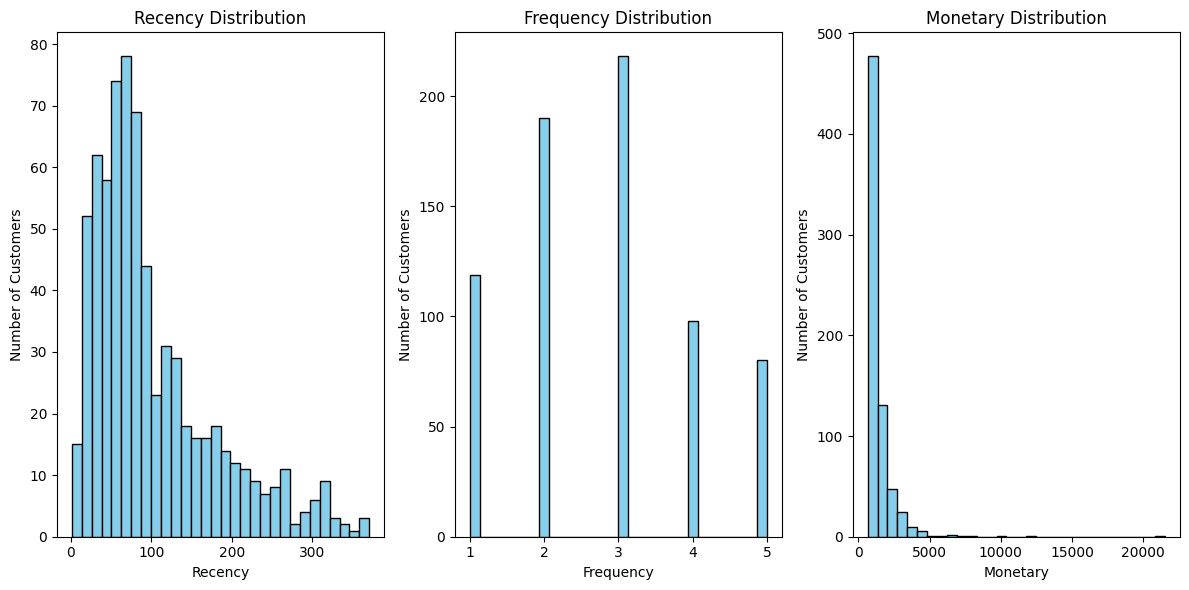


--- Customer Segment 3 ---
Number of Customers: 786

RFM Statistics:
          Recency   Frequency     Monetary
count  786.000000  786.000000   786.000000
mean    20.759542    2.029262   400.968995
std     13.929831    1.045663   269.044899
min      0.000000    1.000000 -1165.300000
25%      9.000000    1.000000   212.045000
50%     19.000000    2.000000   354.810000
75%     31.000000    3.000000   537.807500
max     49.000000    8.000000  1479.220000


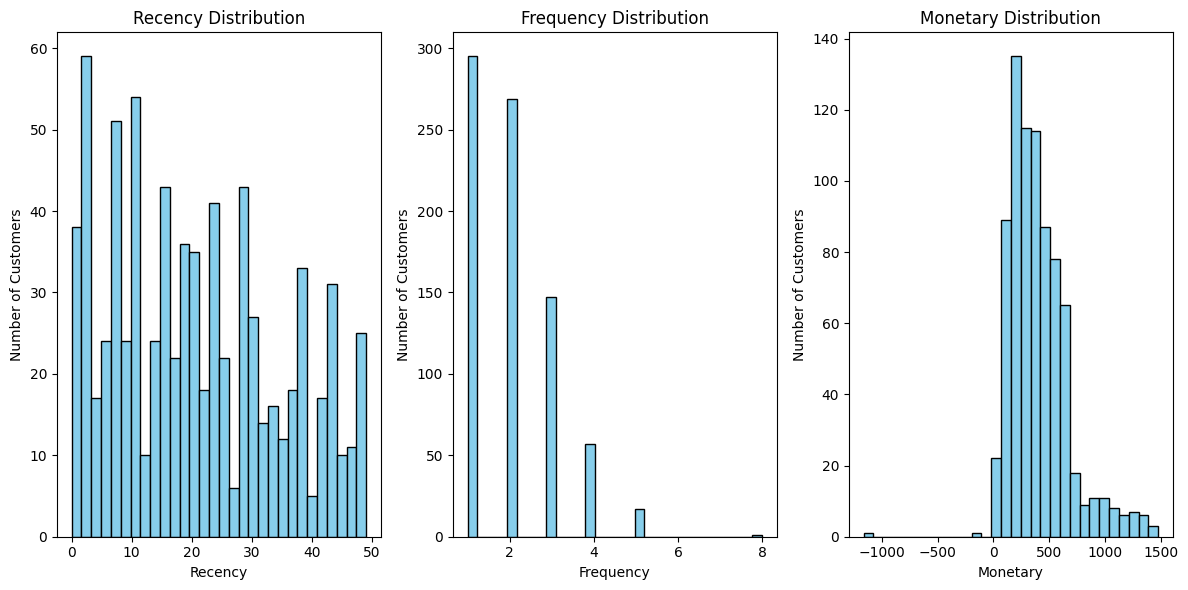

In [34]:
# Profile each customer segment
for cluster in rfm_df['Cluster'].unique():
    segment_data = rfm_df[rfm_df['Cluster'] == cluster]

    print(f"\n--- Customer Segment {cluster} ---")
    print("Number of Customers:", len(segment_data))

    # Analyze RFM scores
    rfm_stats = segment_data[['Recency', 'Frequency', 'Monetary']].describe()
    print("\nRFM Statistics:")
    print(rfm_stats)

    # Other relevant attributes can be analyzed similarly

    # You can also visualize the distribution of RFM scores within each segment
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.hist(segment_data['Recency'], bins=30, color='skyblue', edgecolor='black')
    plt.title('Recency Distribution')
    plt.xlabel('Recency')
    plt.ylabel('Number of Customers')

    plt.subplot(1, 3, 2)
    plt.hist(segment_data['Frequency'], bins=30, color='skyblue', edgecolor='black')
    plt.title('Frequency Distribution')
    plt.xlabel('Frequency')
    plt.ylabel('Number of Customers')

    plt.subplot(1, 3, 3)
    plt.hist(segment_data['Monetary'], bins=30, color='skyblue', edgecolor='black')
    plt.title('Monetary Distribution')
    plt.xlabel('Monetary')
    plt.ylabel('Number of Customers')

    plt.tight_layout()
    plt.show()


**6. MARKETING RECOMMENDATIONS**

High-Value and Recently Active Customers:

Personalized Offers: Provide exclusive promotions or discounts for their next purchase to capitalize on their recent activity.
Loyalty Programs: Introduce a loyalty program to reward and retain these high-value customers.
Product Recommendations: Utilize personalized product recommendations based on their past purchases to encourage additional buying.

Regular but Less Recent Customers:
Reactivation Campaigns: Launch targeted reactivation campaigns to remind them of your products and services.
Special Promotions: Offer time-limited promotions to incentivize quick re-engagement.
Survey Feedback: Collect feedback through surveys to understand any potential barriers to recent purchases and address them.

High-Frequency but Lower Monetary Value:
 Bundle Offers: Introduce bundled products or package deals to increase the average transaction value.
Cross-Sell Strategies: Implement cross-selling strategies to encourage purchasing complementary products.
Exclusive Memberships: Consider creating a subscription or membership program to incentivize repeat business.

Infrequent and Low-Value Customers:
Win-Back Campaigns: Develop win-back campaigns to re-engage this segment with compelling offers.
Survey and Feedback: Conduct surveys to understand the reasons for infrequent purchases and tailor marketing efforts accordingly.
Incentivized Referrals: Encourage these customers to refer friends through referral programs.

**7. VISUALIZATION**

<ipython-input-35-a402e02cd668>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='Recency', data=rfm_df, palette='Set3')


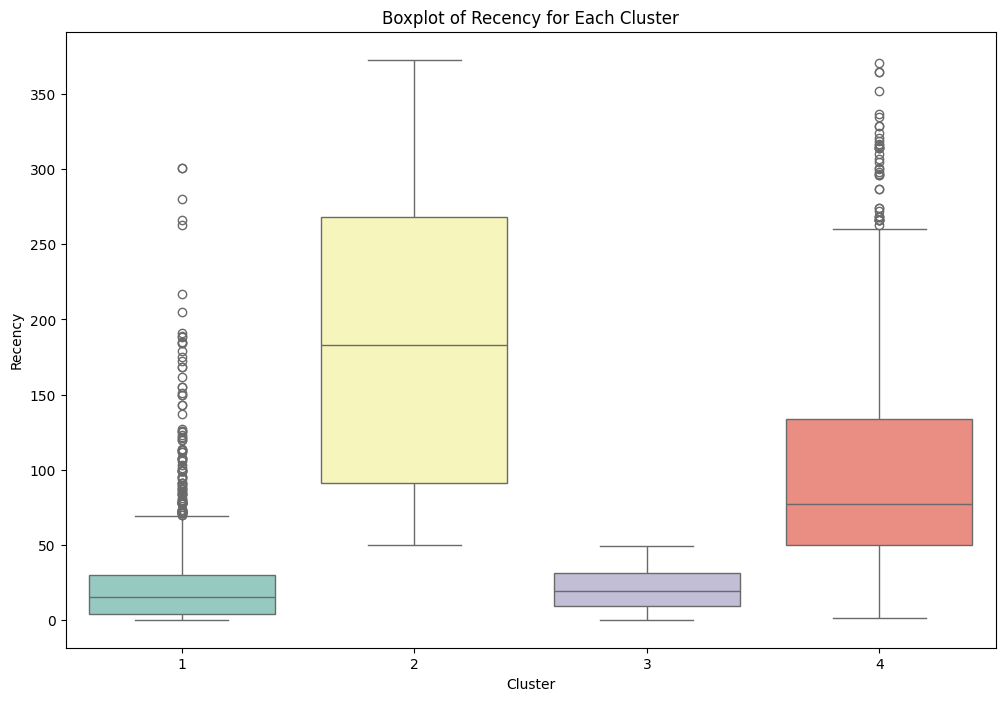

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
# Boxplot for RFM and Cluster Distribution
plt.figure(figsize=(12, 8))
sns.boxplot(x='Cluster', y='Recency', data=rfm_df, palette='Set3')
plt.title('Boxplot of Recency for Each Cluster')
plt.show()


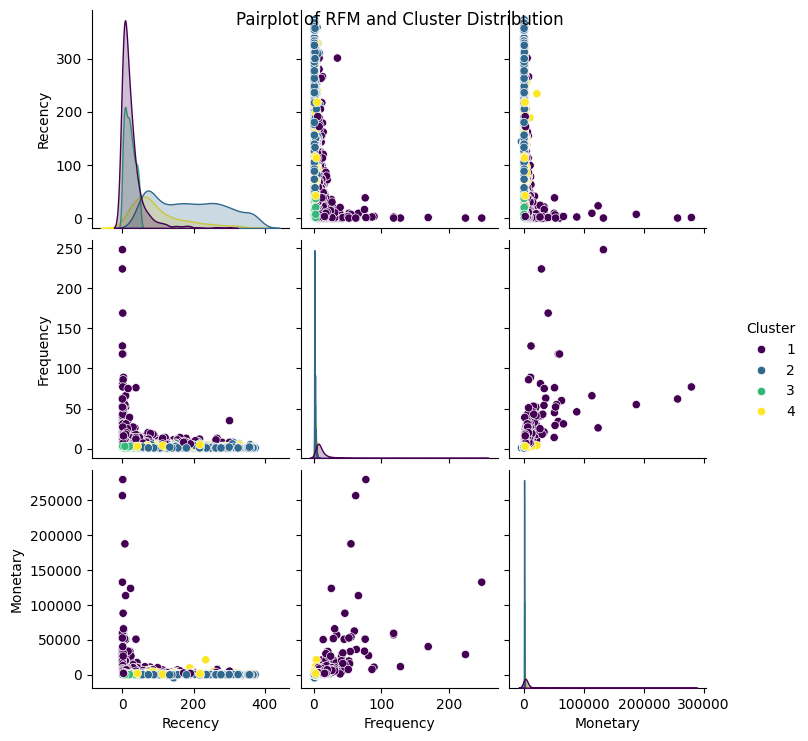

In [36]:
pairplot_data = rfm_df[['Recency', 'Frequency', 'Monetary', 'Cluster']]

# Plot pairplot
sns.pairplot(pairplot_data, hue='Cluster', palette='viridis')
plt.suptitle('Pairplot of RFM and Cluster Distribution')
plt.show()


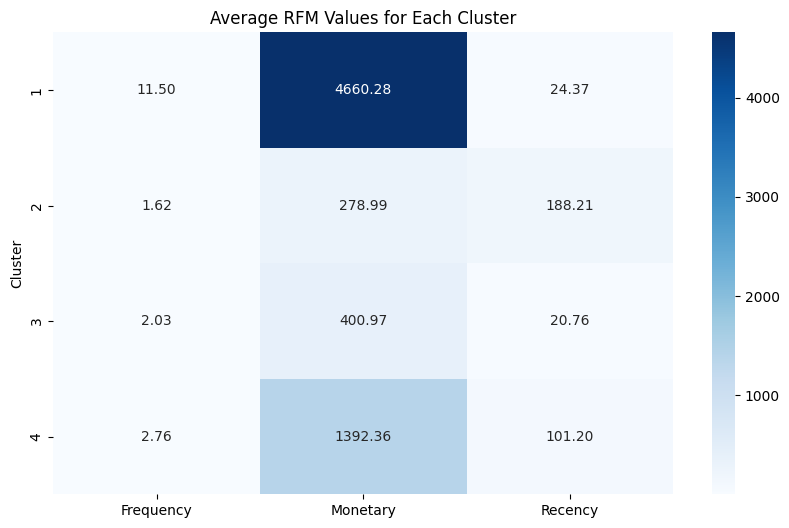

In [37]:
# Heatmap for Cluster Analysis
heatmap_data = rfm_df.pivot_table(index='Cluster', values=['Recency', 'Frequency', 'Monetary'], aggfunc='mean')

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt='.2f')
plt.title('Average RFM Values for Each Cluster')
plt.show()


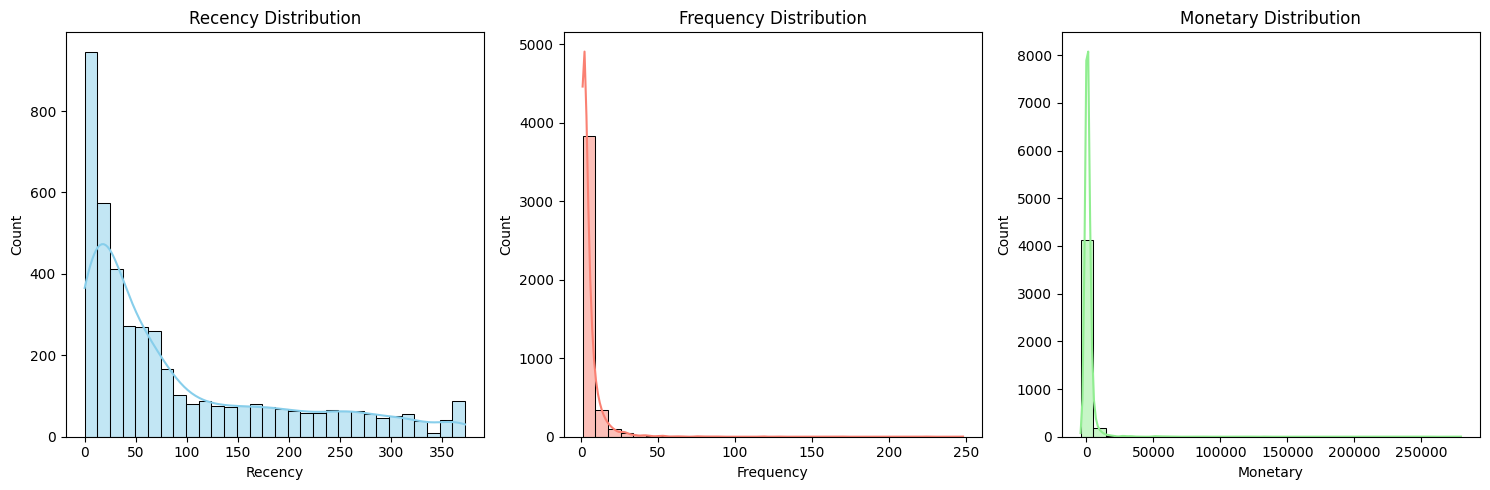

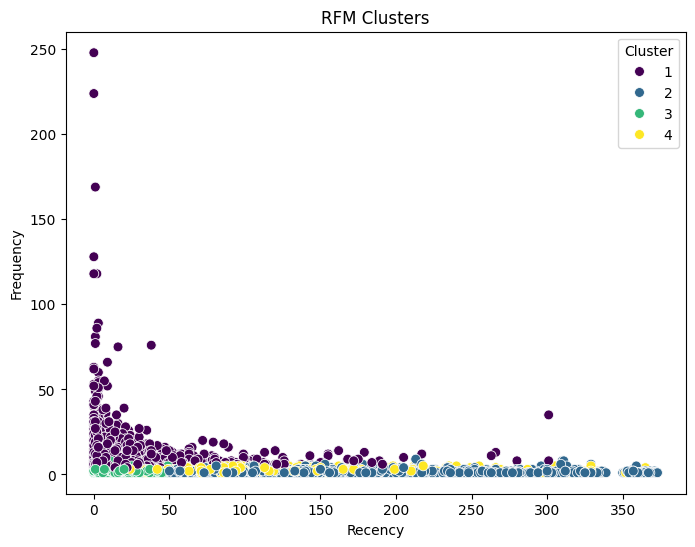

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Visualize the RFM distribution
plt.figure(figsize=(15, 5))

# Recency distribution
plt.subplot(1, 3, 1)
sns.histplot(rfm_df['Recency'], bins=30, color='skyblue', kde=True)
plt.title('Recency Distribution')

# Frequency distribution
plt.subplot(1, 3, 2)
sns.histplot(rfm_df['Frequency'], bins=30, color='salmon', kde=True)
plt.title('Frequency Distribution')

# Monetary distribution
plt.subplot(1, 3, 3)
sns.histplot(rfm_df['Monetary'], bins=30, color='lightgreen', kde=True)
plt.title('Monetary Distribution')

plt.tight_layout()
plt.show()

# Visualize the clusters formed by K-Means
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Recency', y='Frequency', hue='Cluster', data=rfm_df, palette='viridis', s=50)
plt.title('RFM Clusters')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.show()


***Finding solutions to Questions***

**1.Data Overview**

1.1 Size of the dataset in terms of the number of rows and columns

In [39]:
customer.shape

(406829, 9)

1.2  Brief description of each column in the dataset

In [40]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  int64         
 7   Country      406829 non-null  object        
 8   Total Price  406829 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 31.0+ MB


1.3 Time period covered by the dataset

In [41]:
customer['InvoiceDate'].min()

Timestamp('2010-12-01 08:26:00')

In [42]:
customer['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [43]:
time_period= (customer['InvoiceDate'].max() - customer['InvoiceDate'].min()).days
print("The time period covered by the dataset is:", time_period)

The time period covered by the dataset is: 373


**2. CUSTOMER ANALYSIS**

2.1 Unique customers present in the dataset

In [44]:
cust_no =len(customer['CustomerID'].unique())
cust_no

4372

2.2 Distribution of number of orders per customer.

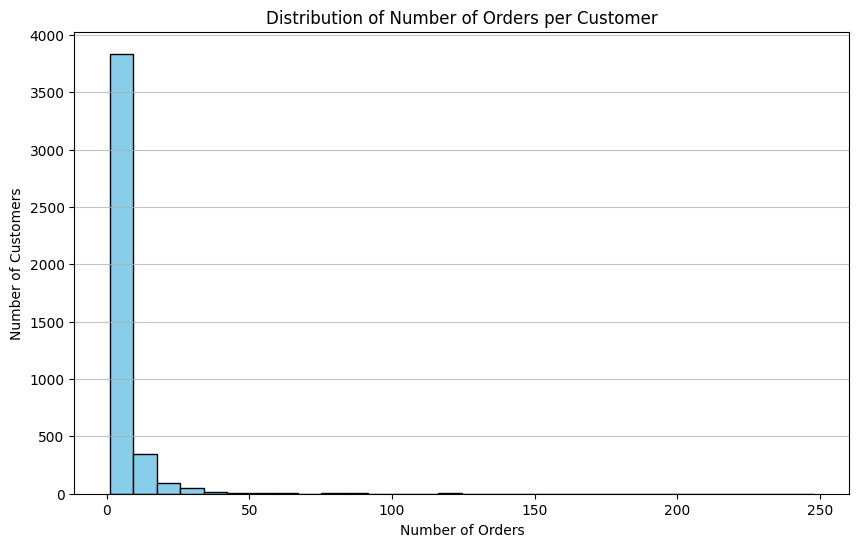

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot a histogram of the number of orders per customer
plt.figure(figsize=(10, 6))
plt.hist(rfm_df['Frequency'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Number of Orders per Customer')
plt.xlabel('Number of Orders')
plt.ylabel('Number of Customers')
plt.grid(axis='y', alpha=0.75)
#plt.xlim(0, 10)

plt.show()


In [46]:
rfm_df['Frequency'].max()

248

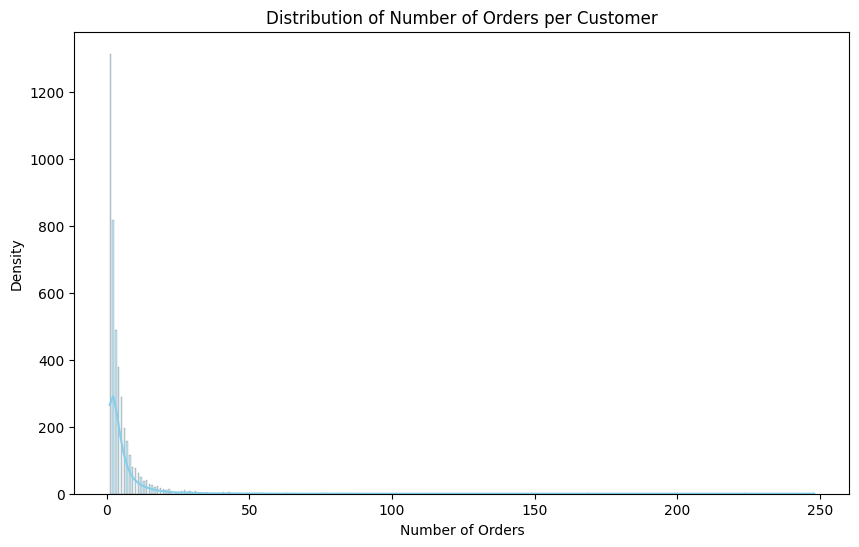

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame with RFM metrics is named rfm_df
# Replace 'rfm_df' with your actual DataFrame name

# Plot a distribution plot (kernel density estimate) of the number of orders per customer
plt.figure(figsize=(10, 6))
sns.histplot(rfm_df['Frequency'], kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of Number of Orders per Customer')
plt.xlabel('Number of Orders')
plt.ylabel('Density')

# Show the plot
plt.show()


2.3 Top 5 Customers who made the most purchases

In [48]:
topCustomers = frequency_data.sort_values(by='Frequency', ascending=False).head(5)
print(topCustomers)

      CustomerID  Frequency
1895       14911        248
330        12748        224
4042       17841        169
1674       14606        128
568        13089        118


**3 PRODUCT ANALYSIS**

3.1 What are the top 10 most frequently purchased products

In [49]:
top_products = customer['Description'].value_counts().head(10)
print(top_products)

WHITE HANGING HEART T-LIGHT HOLDER    2070
REGENCY CAKESTAND 3 TIER              1905
JUMBO BAG RED RETROSPOT               1662
ASSORTED COLOUR BIRD ORNAMENT         1418
PARTY BUNTING                         1416
LUNCH BAG RED RETROSPOT               1358
SET OF 3 CAKE TINS PANTRY DESIGN      1232
POSTAGE                               1196
LUNCH BAG  BLACK SKULL.               1126
PACK OF 72 RETROSPOT CAKE CASES       1080
Name: Description, dtype: int64


3.2 Average price of products in the dataset

In [50]:
avg_price= customer['UnitPrice'].sum()/len(customer)
avg_price

3.460471018536043

3.3 Product Category generating highest revenue

In [51]:
maxrev_df = customer.groupby('Description')['Total Price'].sum().reset_index()
maxrev_df

,Description,Total Price
0,4 PURPLE FLOCK DINNER CANDLES,270.76
1,50'S CHRISTMAS GIFT BAG LARGE,2269.75
2,DOLLY GIRL BEAKER,2750.75
3,I LOVE LONDON MINI BACKPACK,1454.00
4,I LOVE LONDON MINI RUCKSACK,4.15
...,...,...
3891,ZINC T-LIGHT HOLDER STARS SMALL,3843.46
3892,ZINC TOP 2 DOOR WOODEN SHELF,92.75
3893,ZINC WILLIE WINKIE CANDLE STICK,2166.75
3894,ZINC WIRE KITCHEN ORGANISER,156.80


In [52]:
max_rev= maxrev_df.loc[maxrev_df['Total Price'].idxmax(), 'Description']
max_rev

'REGENCY CAKESTAND 3 TIER'

**4. TIME ANALYSIS**

4.1 Is there a specific day of the week or time of day when most orders are placed?

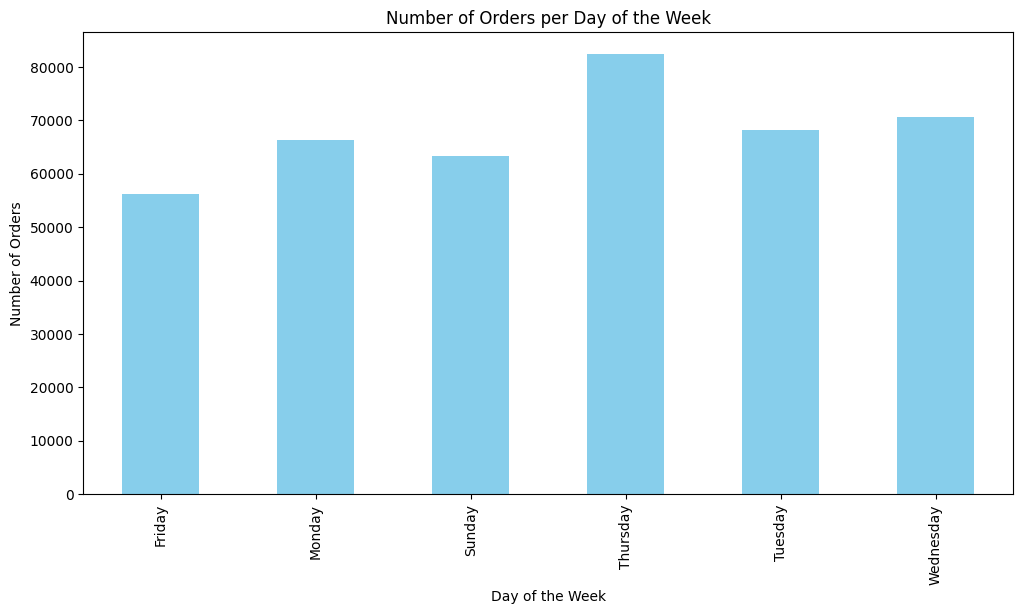

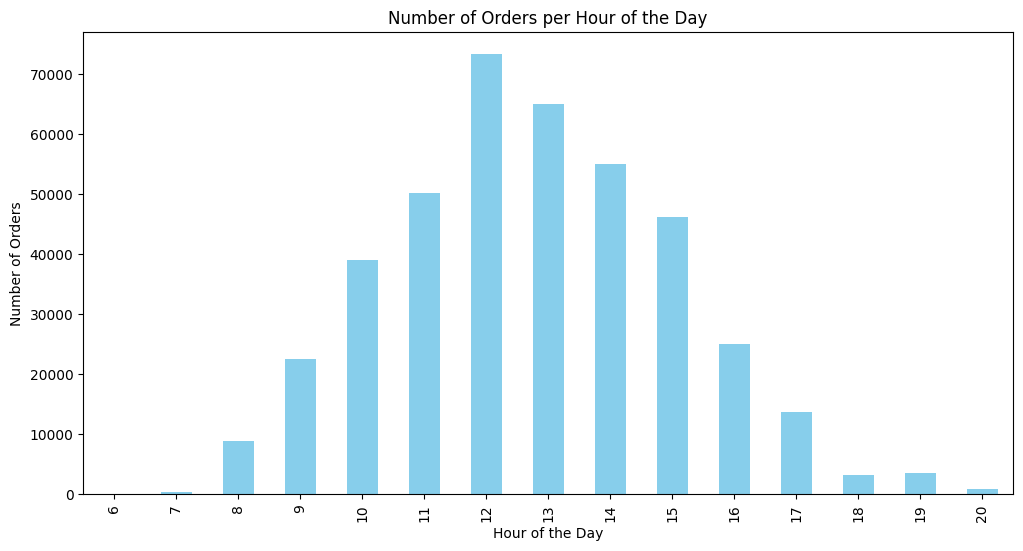

In [53]:
customer['DayOfWeek'] = customer['InvoiceDate'].dt.day_name()
customer['HourOfDay'] = customer['InvoiceDate'].dt.hour
plt.figure(figsize=(12, 6))
customer.groupby('DayOfWeek')['InvoiceNo'].count().plot(kind='bar', color='skyblue')
plt.title('Number of Orders per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Orders')
plt.show()

# Plot the number of orders per hour of the day
plt.figure(figsize=(12, 6))
customer.groupby('HourOfDay')['InvoiceNo'].count().plot(kind='bar', color='skyblue')
plt.title('Number of Orders per Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Orders')
plt.show()

4.2  What is the average order processing time?

As there is no relevant column for the same, the average order processing can't be calculated. However, if a feature mentioning the order confirmation time is present, it can be calculated for every record

4.3 Are there any seasonal trends in the dataset?

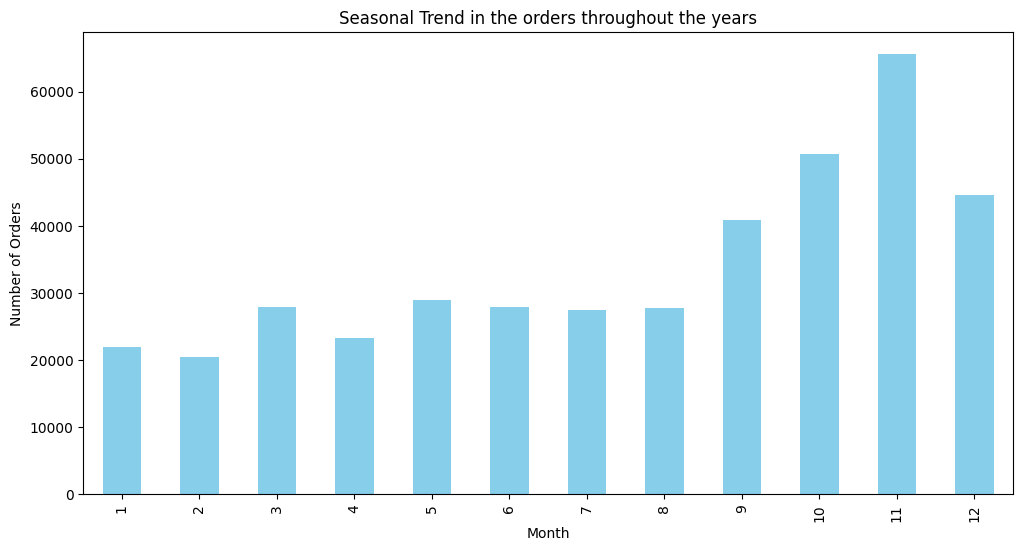

In [54]:
customer['Month'] = customer['InvoiceDate'].dt.month
plt.figure(figsize=(12, 6))
customer.groupby('Month')['InvoiceNo'].count().plot(kind='bar', color='skyblue')
plt.title('Seasonal Trend in the orders throughout the years')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.show()

The shopping trend increases around winters, or the holidays as people tend to buy gifts for their loved ones around the festivals

**5. GEOGRAPHICAL ANALYSIS**

5.1 Top 5 countries with the highest number of orders

In [55]:
top_countries=  customer['Country'].value_counts().head(5)
top_countries

United Kingdom    361878
Germany             9495
France              8491
EIRE                7485
Spain               2533
Name: Country, dtype: int64

5.2 correlation between the country of the customer and the average order
value

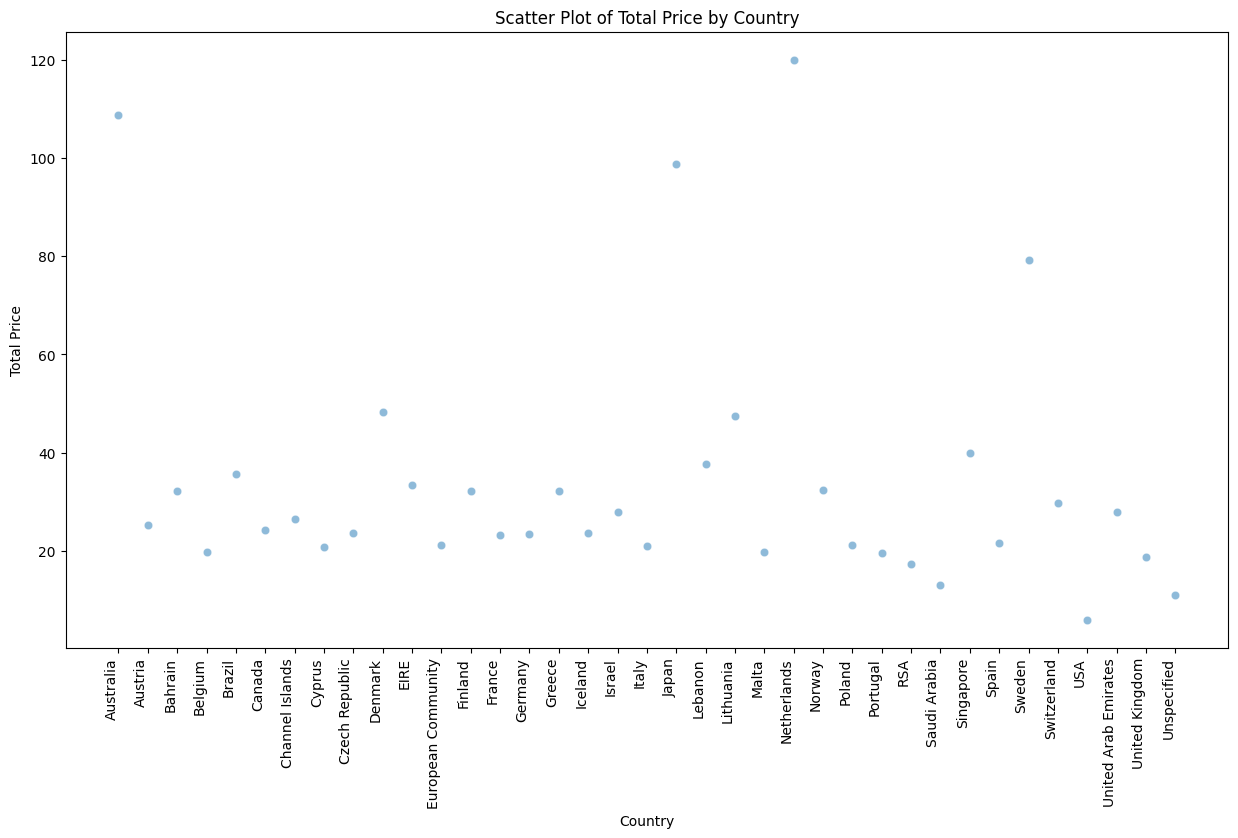

In [56]:
avg_order_value_by_country = customer.groupby('Country')['Total Price'].mean().reset_index()

# Check the correlation
plt.figure(figsize=(15, 8))
sns.scatterplot(x='Country', y='Total Price', data=avg_order_value_by_country, alpha=0.5)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90, ha='right')

plt.xlabel('Country')
plt.ylabel('Total Price')
plt.title('Scatter Plot of Total Price by Country')

# Show the plot
plt.show()

In [57]:
avg_order_value_by_country = customer.groupby('Country')['Total Price'].mean().reset_index()
avg_order_value_by_country

,Country,Total Price
0,Australia,108.877895
1,Austria,25.322494
2,Bahrain,32.258824
3,Belgium,19.773301
4,Brazil,35.737500
5,Canada,24.280662
6,Channel Islands,26.499063
7,Cyprus,20.813971
8,Czech Republic,23.590667
9,Denmark,48.247147


**6. Payment Analysis**

In [58]:
import random
payment= ['VISA', 'Master Card', 'Apple Pay', 'American Express', 'Discover', 'Google Pay', 'Paypal']
random.seed(42)
customer['Mode of Payment']= np.random.choice(payment, size= len(customer))
customer

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total Price,DayOfWeek,HourOfDay,Month,Mode of Payment
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,Wednesday,8,12,Master Card
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Wednesday,8,12,Apple Pay
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,Wednesday,8,12,Master Card
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Wednesday,8,12,American Express
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Wednesday,8,12,Discover
...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20,Friday,12,12,Paypal
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60,Friday,12,12,Discover
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60,Friday,12,12,Discover
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60,Friday,12,12,Master Card


In [59]:
top_payment=  customer['Mode of Payment'].value_counts().head(5)
top_payment

Google Pay          58332
American Express    58281
Paypal              58257
VISA                58185
Apple Pay           57990
Name: Mode of Payment, dtype: int64

6.2 Relationship between the payment method and the order amount

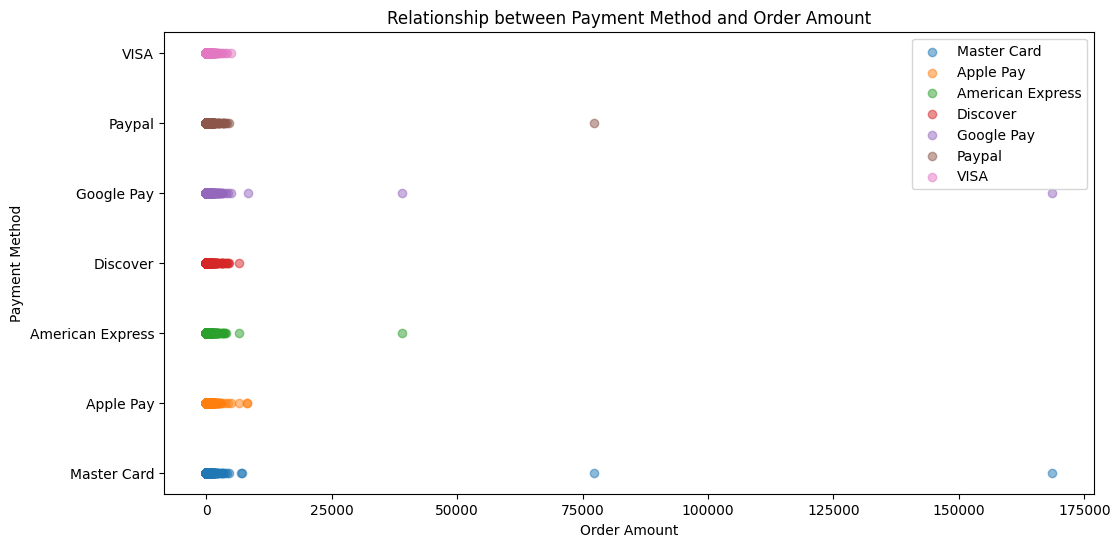

In [60]:
customer['AbsTotPrice'] = customer['Total Price'].abs()
plt.figure(figsize=(12, 6))
for p in customer['Mode of Payment'].unique():
    subset = customer[customer['Mode of Payment'] == p]
    plt.scatter(subset['AbsTotPrice'], subset['Mode of Payment'], label=p, alpha=0.5)

plt.title('Relationship between Payment Method and Order Amount')
plt.xlabel('Order Amount')
plt.ylabel('Payment Method')
plt.legend()
plt.show()

As seen from the sample data generated for mode of payment, there doesn't seem to be any relation between the order amount and payment method

**7. Customer Behavior**

7.1 How long, on average, do customers remain active (between their first and last
purchase)?

In [61]:
customer_activity = customer.groupby('CustomerID')['InvoiceDate'].agg(['min', 'max'])

# Calculate the duration of activity for each customer
customer_activity['Duration'] = customer_activity['max'] - customer_activity['min']

# Calculate the average duration across all customers
average_duration = customer_activity['Duration'].mean()

print(f"Average Duration of Customer Activity: {average_duration}")

Average Duration of Customer Activity: 133 days 17:25:29.204025618


7.2 customer segments based on their purchase behavior

The customer segments based on purchase behavior are

*   High-Value and Recently Active Customers
*   Regular but Less Recent Customers
*   High-Frequency but Lower Monetary Value
*   Infrequent and Low-Value Customers





**8. RETURNS AND REFUNDS**

8.1 What is the percentage of orders that have experienced returns or refunds?

In [62]:
neg_quant= customer[customer['Quantity']<0]
print("percentage of orders that have experienced returns or refunds: ", len(neg_quant)/len(customer)*100, "%")

percentage of orders that have experienced returns or refunds:  2.188880340388714 %


8.2 Is there a correlation between the product category and the likelihood of returns?

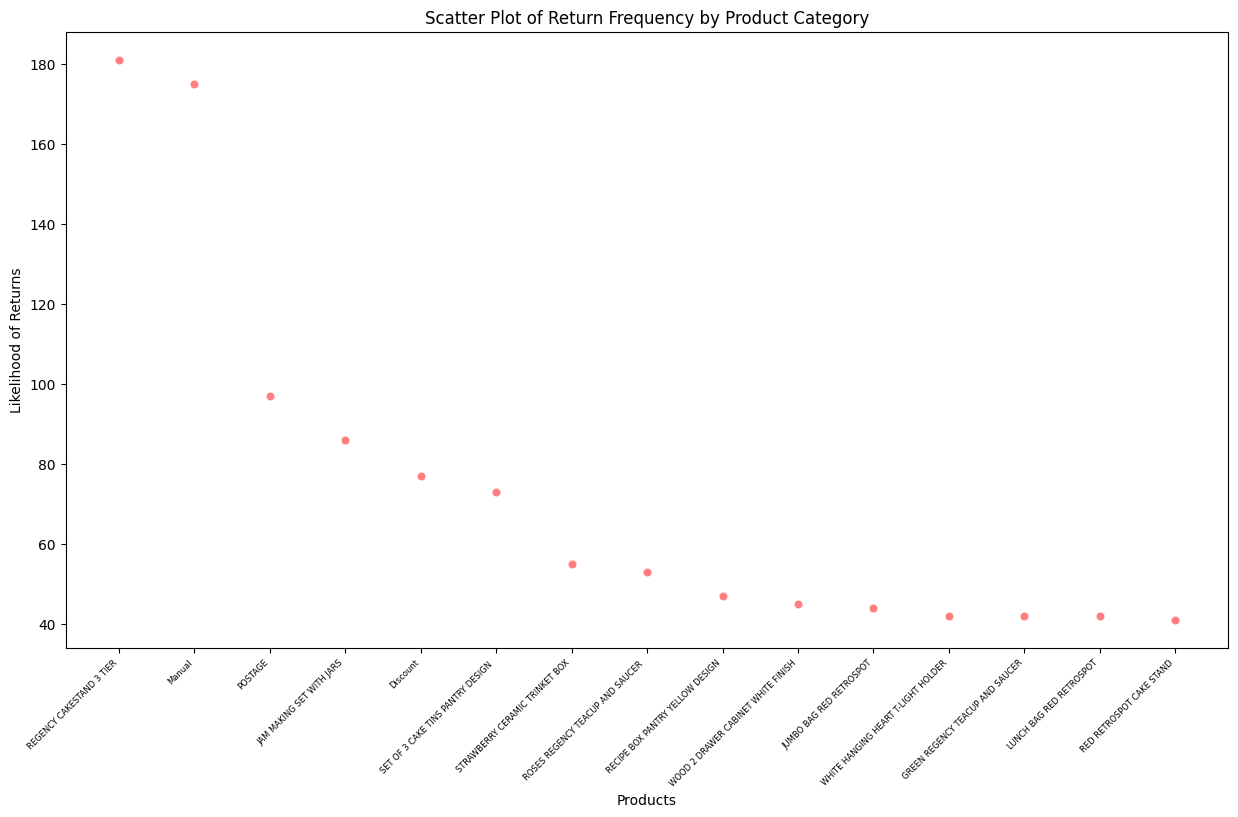

In [63]:
neg_df = neg_quant.groupby('Description').size().reset_index()
neg_df.columns = ['Description', 'Return Frequency']
neg_df = neg_df.sort_values(by='Return Frequency', ascending=False).head(15)



plt.figure(figsize=(15, 8))
sns.scatterplot(x='Description', y='Return Frequency', data=neg_df, alpha=0.5, color='red')
plt.xticks(rotation=45, ha='right', fontsize=6)

plt.xlabel('Products')
plt.ylabel('Likelihood of Returns')
plt.title('Scatter Plot of Return Frequency by Product Category')
plt.show()
